In [ ]:
!pip install tensorflow matplotlib opencv-python numpy pandas

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
import cv2

In [ ]:
classes = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
target_names = [str(i) for i in range(43)]
data = tf.keras.utils.image_dataset_from_directory("/kaggle/input/gtsrb-german-traffic-sign/train", image_size=(32, 32), batch_size=32, class_names=target_names)


In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].max()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1) + 1

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation="relu", padding='same'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation="relu", padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation="relu", padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(43, activation="softmax")
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/logs")
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, earlystopping_callback])

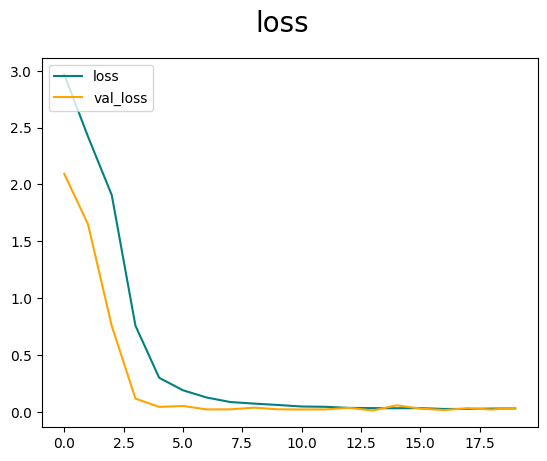

In [ ]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
pre = Precision(name="accuracy")
rec = Recall(name="recall")
acc = SparseCategoricalAccuracy(name="accuracy")

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch

    yhat_probs = model.predict(X)

    yhat_classes = np.argmax(yhat_probs, axis=1)

    acc.update_state(y, yhat_probs)

    y_one_hot = tf.one_hot(y, depth=43)
    pre.update_state(y_one_hot, yhat_probs)
    rec.update_state(y_one_hot, yhat_probs)


In [ ]:
print(f"Accuracy: {acc.result().numpy():.4f}")
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {rec.result().numpy():.4f}")


Accuracy: 0.9948
Precision: 0.9962
Recall: 0.9932


In [ ]:
def predict_from_path(model, path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(img, (32,32))
    predictions = model.predict(np.expand_dims(img/255, 0))
    y_hat = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)
    return y_hat, confidence

In [ ]:
path = "/kaggle/school.png"
try:
    y_hat_index, confidence = predict_from_path(model, path)
    predicted_label = classes[y_hat_index]
    print(f"Class ID:    {y_hat_index}")
    print(f"Label:       {predicted_label}")
    print(f"Confidence:  {confidence * 100:.2f}%")
except Exception as e:
    print(f"Error predicting image: {e}")